In [1]:
from customerManager import CustomerManager
customer_path = "./config/customer_classes.json"
cManager = CustomerManager(file_path = customer_path)

In [12]:
import numpy as np
from scipy.special import erfc

class Learner():
    def __init__(self):
        self.n_bids = 10
        self.n_price= 13
        self.n_arms =  self.n_bids*self.n_price
        self.bid = np.linspace(1.0, 10.0, self.n_bids)
        self.bid = np.linspace(3.0, 15.0, self.n_price)
        self.t = 0 
        
        
        self.rewards_per_arm = x = [[[] for i in range(self.n_price)] for i in range(self.n_bids)]
        self.collected_rewards = []
    
    def update_observations(self, pulled_arm_bid,pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward*10000)

class TS_Learner(Learner):
    def __init__(self, safety_t = 0.2):
        super().__init__()
        self.safety_t = safety_t
        #Mean and Std
        self.normal_parameters = np.zeros((self.n_bids,self.n_price, 2))

    def pull_arm(self):
        if self.t < (2*self.n_arms): return (self.t % self.n_bids) + 1,(self.t % self.n_price) +3 # controllar ebene che sia corretto

        #Safety constraint
        #Alternative implementation safety constraints using MATH         
        arg_max = [[] for i in range(self.n_bids)]
        for b_index in range(self.n_bids) : 
            for p in self.normal_parameters[b_index]:
                if 0.5 * erfc(p[0]/(np.sqrt(2)*p[1])) > self.safety_t :
                    arg_max[b_index].append(0.0) 
                else : 
                    arg_max[b_index].append(np.random.normal(p[0], p[1]))
        
        result = np.where(arg_max == np.amax(arg_max))
        listOfCordinates = list(zip(result[0], result[1]))
      
        return listOfCordinates[0][0] + 1,listOfCordinates[0][1] + 3  #index Bid and price conversion

    def update(self, pulled_arm_bid,pulled_arm_price, reward):
        self.t += 1
        pulled_arm_bid -= 1  #Bid index conversion
        pulled_arm_price -= 3  #price index conversion
        times_pulled = max(1, len(self.rewards_per_arm[pulled_arm_bid][pulled_arm_price]))
        self.update_observations(pulled_arm_bid,pulled_arm_price, reward)
        #Empirical mean
        self.normal_parameters[pulled_arm_bid][pulled_arm_price][0] = (self.normal_parameters[pulled_arm_bid][pulled_arm_price][0] * (times_pulled - 1) + reward ) / times_pulled
        #Empirical std
        #NOt gooooood Should depend on the number of sampl (inversionally proportional)
        self.normal_parameters[pulled_arm_bid][pulled_arm_price][1] = np.sqrt(sum((self.normal_parameters[pulled_arm_bid][pulled_arm_price][0] - self.rewards_per_arm[pulled_arm_bid][pulled_arm_price])**2)/times_pulled**2)


In [13]:
opt_bids = [3.8622484787564275 , 2.1216094606111944,  2.347134281066495]
opt_price = 6.321089806558111

In [18]:
from environment import Environment
from tqdm import tqdm

price = 5.0

T = 365
env = Environment(noise_variance= 0.10)
regret = []
ts_learner = TS_Learner()
ts_rewards_per_experiment = np.ndarray([])

regret=[]
sols = []

for t in tqdm(range(T)):
    #TS learner 
    bid,price = ts_learner.pull_arm()
    bids = [bid,bid,bid]
    sols.append([bid,price])
    reward = env.round(bids,price)
    ts_learner.update(bid,price, sum(reward)/10000)

    regret.append(sum(env.round(opt_bids, opt_price, noise = False)) - sum(reward))



100%|██████████| 365/365 [00:00<00:00, 855.81it/s] 


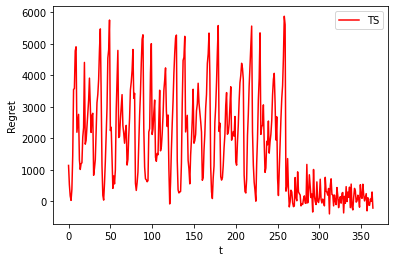

In [19]:
import matplotlib.pyplot as plt 

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(regret , 'r')
plt.legend(["TS" ])
plt.show()

In [20]:
regret[-10:]

[135.197675387044,
 245.76193182090446,
 -300.9152203453914,
 114.59525006512104,
 -110.81719660013141,
 -125.97169169128028,
 75.28924637153341,
 2.9335773661878193,
 297.7535872980252,
 -211.84089520473844]

In [21]:
sols[-20:]

[[3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 7],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 6],
 [3, 7]]